In [1]:
import torch
import matplotlib.pyplot as plt
import os
import struct

In [2]:
from transformers import GPT2LMHeadModel
from transformers import AutoTokenizer
from transformers import LlamaForCausalLM
from transformers import T5ForConditionalGeneration

In [3]:
models = {
    "gpt2": GPT2LMHeadModel.from_pretrained("/home/styaeng/project/delta-compress/pretrained_model/gpt2"),
    "llama2": LlamaForCausalLM.from_pretrained("/home/styaeng/project/delta-compress/pretrained_model/llama2"),
    "t5": T5ForConditionalGeneration.from_pretrained("/home/styaeng/project/delta-compress/pretrained_model/t5")
}

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [34]:
def get_exponential(model, s, e):
    '''____________________________________________________
    |      |                    |                      |
    |  s   |    exponential     |       mantissa       |
    |______|____________________|_____________________ |
    |  2   | 3-7                |   8-17               |
    '''
    for idx, (name, param) in enumerate(model.named_parameters()):
        if param.ndim == 2:
            # print(name + ' --> ' + f'{param.shape}')
            dim0, dim1 = param.shape
            tl = list(
                map(lambda x: int(
                        "{}".format(
                                bin(
                                    int.from_bytes(
                                    struct.pack('>e', x), byteorder='big'
                                    )
                                )[s:e]
                            ), 
                            base=2
                    ),
                    param.abs().neg().reshape(-1).tolist()
                )
            )


            t = torch.tensor(tl, dtype=torch.int32).reshape(dim0, dim1)
    return t

# hf2b = lambda x: bin(int.from_bytes(struct.pack('>e', x), byteorder='big'))

In [35]:
weight = get_exponential(models['t5'].half(), 3, 8)

In [36]:
weight

tensor([[12, 12, 11,  ...,  9, 14, 13],
        [ 7, 11, 11,  ..., 14, 13, 12],
        [13, 11, 13,  ..., 14, 13, 12],
        ...,
        [13, 12, 13,  ...,  9,  9, 12],
        [17, 15, 14,  ..., 15, 16, 13],
        [12, 10, 12,  ..., 11, 12, 12]], dtype=torch.int32)

In [4]:
model = models['t5']
s, e = 3, 8

In [13]:
'''_________________________________________________
|      |                    |                      |
|  s   |    exponential     |       mantissa       |
|______|____________________|_____________________ |
|  2   | 3-7                |   8-17               |
'''
exponent = dict()
for idx, (name, param) in enumerate(model.named_parameters()):
    if param.ndim == 2:
        # print(name + ' --> ' + f'{param.shape}')
        dim0, dim1 = param.shape
        tl = list(
            map(lambda x: int(
                    "{}".format(
                            bin(
                                int.from_bytes(
                                struct.pack('>e', x), byteorder='big'
                                )
                            )[s:e]
                        ), 
                        base=2
                ),
                param.abs().neg().reshape(-1).tolist()
            )
        )
        t = torch.tensor(tl, dtype=torch.float32).reshape(dim0, dim1)
    exponent[name] = t

In [20]:
for k in exponent.keys():
    print(k)

shared.weight
encoder.block.0.layer.0.SelfAttention.q.weight
encoder.block.0.layer.0.SelfAttention.k.weight
encoder.block.0.layer.0.SelfAttention.v.weight
encoder.block.0.layer.0.SelfAttention.o.weight
encoder.block.0.layer.0.SelfAttention.relative_attention_bias.weight
encoder.block.0.layer.0.layer_norm.weight
encoder.block.0.layer.1.DenseReluDense.wi.weight
encoder.block.0.layer.1.DenseReluDense.wo.weight
encoder.block.0.layer.1.layer_norm.weight
encoder.block.1.layer.0.SelfAttention.q.weight
encoder.block.1.layer.0.SelfAttention.k.weight
encoder.block.1.layer.0.SelfAttention.v.weight
encoder.block.1.layer.0.SelfAttention.o.weight
encoder.block.1.layer.0.layer_norm.weight
encoder.block.1.layer.1.DenseReluDense.wi.weight
encoder.block.1.layer.1.DenseReluDense.wo.weight
encoder.block.1.layer.1.layer_norm.weight
encoder.block.2.layer.0.SelfAttention.q.weight
encoder.block.2.layer.0.SelfAttention.k.weight
encoder.block.2.layer.0.SelfAttention.v.weight
encoder.block.2.layer.0.SelfAttentio

In [22]:
exponent['encoder.block.0.layer.0.SelfAttention.q.weight'].shape

torch.Size([512, 512])

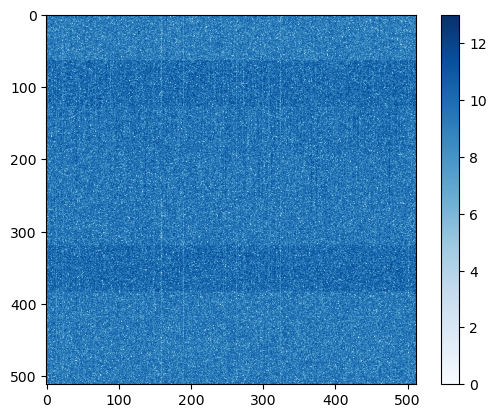

In [91]:
plt.imshow(exponent['encoder.block.0.layer.0.SelfAttention.q.weight'], cmap="Blues")
plt.colorbar()
plt.show()

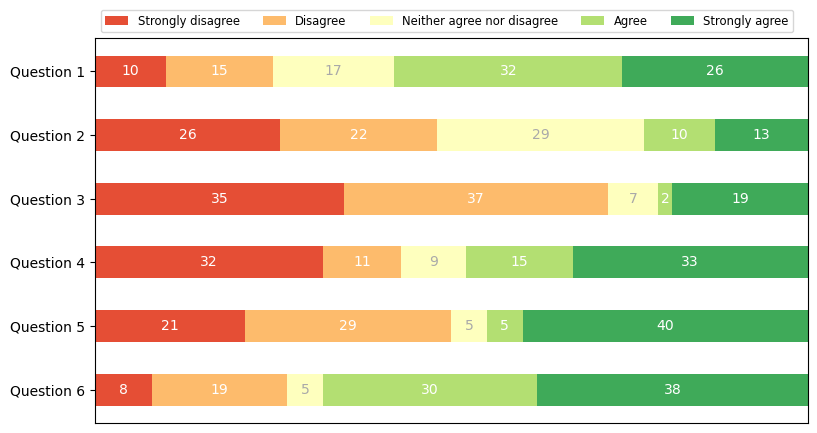

In [156]:
import matplotlib.pyplot as plt
import numpy as np

category_names = ['Strongly disagree', 'Disagree',
                  'Neither agree nor disagree', 'Agree', 'Strongly agree']
results = {
    'Question 1': [10, 15, 17, 32, 26],
    'Question 2': [26, 22, 29, 10, 13],
    'Question 3': [35, 37, 7, 2, 19],
    'Question 4': [32, 11, 9, 15, 33],
    'Question 5': [21, 29, 5, 5, 40],
    'Question 6': [8, 19, 5, 30, 38]
}


def survey(results, category_names):
    """
    Parameters
    ----------
    results : dict
        A mapping from question labels to a list of answers per category.
        It is assumed all lists contain the same number of entries and that
        it matches the length of *category_names*.
    category_names : list of str
        The category labels.
    """
    labels = list(results.keys())
    data = np.array(list(results.values()))
    data_cum = data.cumsum(axis=1)
    category_colors = plt.colormaps['RdYlGn'](
        np.linspace(0.15, 0.85, data.shape[1]))

    fig, ax = plt.subplots(figsize=(9.2, 5))
    ax.invert_yaxis()
    ax.xaxis.set_visible(False)
    ax.set_xlim(0, np.sum(data, axis=1).max())

    for i, (colname, color) in enumerate(zip(category_names, category_colors)):
        widths = data[:, i]
        starts = data_cum[:, i] - widths
        rects = ax.barh(labels, widths, left=starts, height=0.5,
                        label=colname, color=color)

        r, g, b, _ = color
        text_color = 'white' if r * g * b < 0.5 else 'darkgrey'
        ax.bar_label(rects, label_type='center', color=text_color)
    ax.legend(ncols=len(category_names), bbox_to_anchor=(0, 1),
              loc='lower left', fontsize='small')

    return fig, ax


survey(results, category_names)
plt.show()